## Baseline model with all clues

### Data Import

In [63]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from torchvision import models, transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import pandas as pd
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns
from sklearn.metrics import classification_report
from sklearn.metrics import precision_score, recall_score, f1_score
import warnings
warnings.filterwarnings("ignore")

## Data preprocessing

In [43]:
clues = pd.read_csv('clues.csv', index_col=0)
clues.shape

(10000, 3)

In [44]:
labels = pd.read_csv('selected_labels.csv')
labels = labels.drop(columns=['Ball', 'Gate', 'referee Image'])

In [45]:
LABELS = [
    'Start/Restar the game',
    'The joy of the players',
    'yellow card',
    'Red Card',
    'Stadium View',
    'Penalty Image',
    'Free Kick',
    'Generic Moment'
]

In [46]:
# visualize the mapping from label names to indices
label_to_index = {label: idx for idx, label in enumerate(LABELS)}
label_to_index

{'Start/Restar the game': 0,
 'The joy of the players': 1,
 'yellow card': 2,
 'Red Card': 3,
 'Stadium View': 4,
 'Penalty Image': 5,
 'Free Kick': 6,
 'Generic Moment': 7}

In [47]:
labels['label'] = labels[LABELS].idxmax(axis=1).map({label: idx for idx, label in enumerate(LABELS)})
labels['label'] = labels['label'].astype(int)

In [48]:
labels = labels.drop(columns=LABELS)

In [49]:
# model parameters
batch_size = 32
learning_rate = 0.001
num_epochs = 10
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], 
                         [0.229, 0.224, 0.225])
])

In [50]:
class FootballDataset(Dataset):
    def __init__(self, df, clues_df, image_folder, transform=None):

        self.df = df
        self.clues_df = clues_df
        self.image_folder = image_folder
        self.transform = transform
        

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        main_row = self.df.iloc[idx]
        
        # corresponding row from clues DataFrame
        clues_row = self.clues_df.iloc[idx]
        
        img_path = os.path.join(self.image_folder, str(main_row['Image Number']) + '.jpg')
        image = Image.open(img_path).convert('RGB')
        
        label = main_row['label']
        
        binary_features = torch.tensor([
            float(clues_row['Ball']), 
            float(clues_row['Gate']), 
            float(clues_row['Referee'])
        ], dtype=torch.float32)
        
        if self.transform:
            image = self.transform(image)
            
        return image, label, binary_features

In [51]:
image_path = 'data/selected_images'

train_val_df, test_df = train_test_split(labels, test_size=0.2, random_state=42)
train_df, val_df = train_test_split(train_val_df, test_size=0.1, random_state=42)

train_dataset = FootballDataset(
    df=train_df,  
    clues_df=clues,
    image_folder='data/selected_images',
    transform=transform
)

val_dataset = FootballDataset(
    df=val_df, 
    clues_df=clues,
    image_folder='data/selected_images',
    transform=transform
)

test_dataset = FootballDataset(
    df=test_df,  # use test_df instead of test_dataset
    clues_df=clues,
    image_folder='data/selected_images',
    transform=transform
)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

## Model fine-tuning and training

After carrying out all the usual preprocessing, we modify the standard ResNet18 architecture to incorporate additional binary features alongside the visual features extracted from football match images.

In particular, we replace the original fully connected layer with an identity function to maintain ResNet18 as a feature extractor, then we create a new classification head that concatenates the 512-dimensional ResNet features with 3 additional binary features (representing object-level elements like ball presence, referee presence, and goalkeeper presence).\
The modified model loads pre-trained weights from your baseline ResNet18 while adapting the final layer to handle the expanded feature space (515 dimensions total).\
This approach allows us to leverage both the spatial visual information learned by the CNN and explicit contextual clues about key football elements to improve match event classification performance.

In [52]:
class AllClues_ResNet(nn.Module):
    def __init__(self, num_classes=8):
        super(AllClues_ResNet, self).__init__()
        
        self.resnet = models.resnet18(pretrained=True)
        
        fc_input_size = self.resnet.fc.in_features  # 512 for ResNet18
        self.resnet.fc = nn.Identity() 
        
         # we add 3 more feature dimensions for the clues
        self.fc = nn.Linear(fc_input_size + 3, num_classes)
    
    def forward(self, x, binary_features):
        features = self.resnet(x) 
        combined_features = torch.cat((features, binary_features), dim=1)  # Add clues
        return self.fc(combined_features)

In [54]:
num_classes = len(LABELS)

clues_model = AllClues_ResNet(num_classes=num_classes)

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
clues_model = clues_model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(clues_model.parameters(), lr=learning_rate)

In [57]:
train_acc, val_acc, train_loss, val_loss = [], [], [], []
best_val_loss = float('inf')


for epoch in range(num_epochs):
    clues_model.train()
    running_loss = 0.0
    correct, total = 0, 0

    for images, labels, binary_features in train_loader:
        images = images.to(device)
        labels = labels.to(device)
        binary_features = binary_features.to(device)

        optimizer.zero_grad()
        outputs = clues_model(images, binary_features)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    epoch_loss = running_loss / len(train_loader)
    epoch_acc = correct / total * 100
    train_loss.append(epoch_loss)
    train_acc.append(epoch_acc)

    clues_model.eval()
    val_running_loss = 0.0
    val_correct, val_total = 0, 0

    with torch.no_grad():
        
        for images, labels, binary_features in val_loader:
            images = images.to(device)
            labels = labels.to(device)
            binary_features = binary_features.to(device)
            
            outputs = clues_model(images, binary_features)
            loss = criterion(outputs, labels)

            val_running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            val_correct += (preds == labels).sum().item()
            val_total += labels.size(0)

    val_epoch_loss = val_running_loss / len(val_loader)
    val_epoch_acc = val_correct / val_total * 100
    val_loss.append(val_epoch_loss)
    val_acc.append(val_epoch_acc)

    print(f"[{epoch+1}/{num_epochs}] Train Loss: {epoch_loss:.4f}, Acc: {epoch_acc:.2f}%, Val Loss: {val_epoch_loss:.4f}, Acc: {val_epoch_acc:.2f}%")
    
    if val_epoch_loss < best_val_loss:
        best_val_loss = val_epoch_loss
        torch.save(clues_model.state_dict(), 'models/resnet18_all_clues.pth')
        print("Saved new best model!\n")

print("Training complete.")

[1/10] Train Loss: 0.4109, Acc: 86.24%, Val Loss: 0.4504, Acc: 83.38%
Saved new best model!

[2/10] Train Loss: 0.2826, Acc: 90.24%, Val Loss: 0.7236, Acc: 79.88%
[3/10] Train Loss: 0.2069, Acc: 93.22%, Val Loss: 0.6270, Acc: 82.00%
[4/10] Train Loss: 0.1453, Acc: 95.07%, Val Loss: 0.6185, Acc: 82.50%
[5/10] Train Loss: 0.1303, Acc: 95.83%, Val Loss: 0.5751, Acc: 82.50%
[6/10] Train Loss: 0.0869, Acc: 97.14%, Val Loss: 0.7173, Acc: 82.75%
[7/10] Train Loss: 0.0893, Acc: 97.00%, Val Loss: 0.6306, Acc: 82.38%
[8/10] Train Loss: 0.0711, Acc: 97.44%, Val Loss: 0.8837, Acc: 79.50%
[9/10] Train Loss: 0.0743, Acc: 97.58%, Val Loss: 0.6153, Acc: 84.62%
[10/10] Train Loss: 0.0893, Acc: 96.89%, Val Loss: 0.6451, Acc: 85.12%
Training complete.


## Inference on test set and evaluation

In [58]:
best_clues_model = AllClues_ResNet(num_classes=len(LABELS))
best_clues_model.load_state_dict(torch.load('models/resnet18_all_clues.pth'))
best_clues_model.to(device)
best_clues_model.eval()


all_preds = []
all_labels = []
with torch.no_grad():
    for images, labels, binary_features in test_loader:
        images = images.to(device)
        binary_features = binary_features.to(device)
        
        outputs = best_clues_model(images, binary_features)
        _, preds = torch.max(outputs, 1)
        
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.numpy())

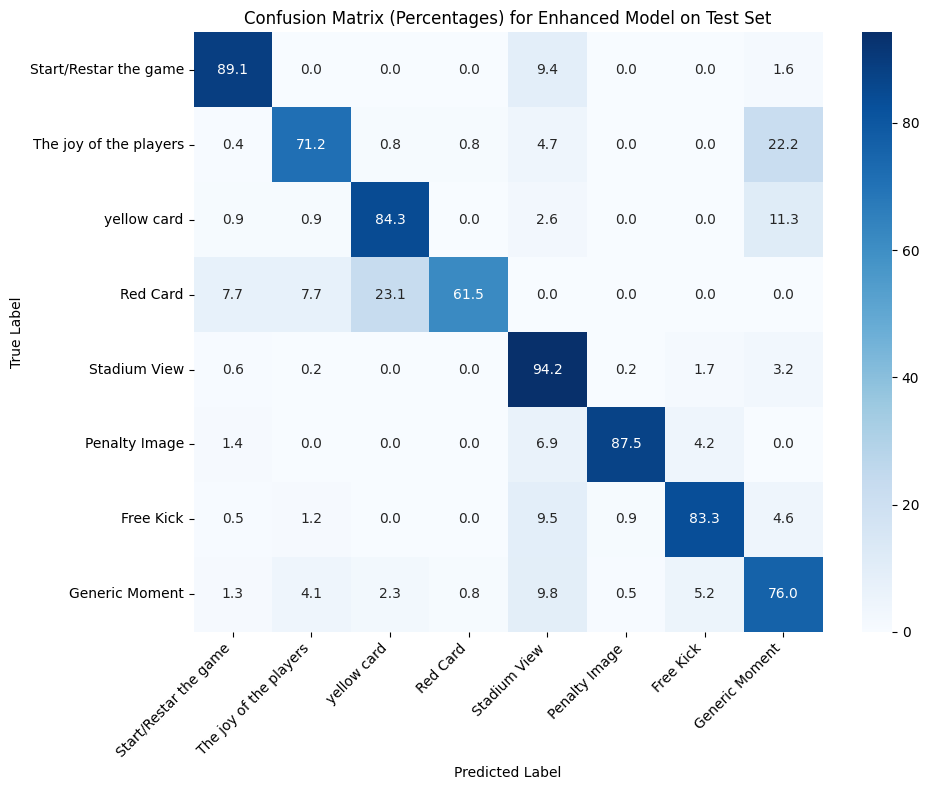

In [59]:
cm = confusion_matrix(all_labels, all_preds, labels=list(range(len(LABELS))))
cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

plt.figure(figsize=(10, 8))
sns.heatmap(cm_percent, annot=True, fmt=".1f", cmap="Blues", xticklabels=LABELS, yticklabels=LABELS)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix (Percentages) for Enhanced Model on Test Set')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig('enhanced_model_confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

In [60]:
all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

class_correct = [0] * len(LABELS)
class_total = [0] * len(LABELS)

for i in range(len(all_labels)):
    label = all_labels[i]
    pred = all_preds[i]
    class_total[label] += 1
    if pred == label:
        class_correct[label] += 1

class_accuracies = [100 * c / t if t > 0 else 0 for c, t in zip(class_correct, class_total)]

overall_accuracy = sum(class_correct) / sum(class_total) * 100

print(f"{'Class':<25}{'Accuracy':>10}")
print("-" * 35)
for label, acc in zip(LABELS, class_accuracies):
    print(f"{label:<25}{acc:>9.2f}")
print("-" * 35)
print(f"{'Overall':<25}{overall_accuracy:>9.2f}")

Class                      Accuracy
-----------------------------------
Start/Restar the game        89.06
The joy of the players       71.21
yellow card                  84.35
Red Card                     61.54
Stadium View                 94.24
Penalty Image                87.50
Free Kick                    83.29
Generic Moment               76.03
-----------------------------------
Overall                      84.20


In [61]:
report = classification_report(all_labels, all_preds, 
                               target_names=LABELS, 
                               digits=3)
print(report)

                        precision    recall  f1-score   support

 Start/Restar the game      0.792     0.891     0.838        64
The joy of the players      0.884     0.712     0.789       257
           yellow card      0.874     0.843     0.858       115
              Red Card      0.615     0.615     0.615        13
          Stadium View      0.856     0.942     0.897       660
         Penalty Image      0.900     0.875     0.887        72
             Free Kick      0.913     0.833     0.871       431
        Generic Moment      0.725     0.760     0.742       388

              accuracy                          0.842      2000
             macro avg      0.820     0.809     0.812      2000
          weighted avg      0.845     0.842     0.841      2000



In [64]:
# Overall weighted metrics
weighted_precision = precision_score(all_labels, all_preds, average='weighted')
weighted_recall = recall_score(all_labels, all_preds, average='weighted')
weighted_f1 = f1_score(all_labels, all_preds, average='weighted')


print(f"Accuracy: {overall_accuracy/100:.3f}")
print(f"Weighted Precision: {weighted_precision:.3f}")
print(f"Weighted Recall: {weighted_recall:.3f}")
print(f"Weighted F1 Score: {weighted_f1:.3f}")

Accuracy: 0.842
Weighted Precision: 0.845
Weighted Recall: 0.842
Weighted F1 Score: 0.841
